**Downloading Packages**

In [1]:
!pip install transformers
!pip install tensorflow-text

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 880 kB 42.9 MB/s 
     |████████████████████████████████| 6.6 MB 31.9 MB/s 
     |████████████████████████████████| 596 kB 47.7 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=81f6dbaa66b986ce0c36fbd22f3278ae77b35a3e026f8404507a3ad34f1c4eeb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 47.4 MB/s 


In [ ]:
!pip install torch-scatter 
!pip install torch-sparse
!pip install torch-geometric

**Importing Packages**

In [2]:
import torch
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np 
from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import reuters
import nltk
# import git
import numpy as np
import os
from transformers import BertTokenizer, BertModel
from google.colab import drive
from keras.layers import Input
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from sklearn.metrics import f1_score
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score

In [ ]:
from torch_geometric.nn import GATv2Conv

**Downloading Dataset**

In [3]:
nltk.download('reuters')
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora
drive.mount('/content/drive')

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

Streaming output truncated to the last 5000 lines.
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflating: /root/nltk_data/corpora/reuters/training/2253  
  inflating: /root/nltk_data/corpor

**Downloading Glove Embedding**

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-05-05 12:30:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-05 12:30:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-05 12:30:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

**Glove representation for words**

In [5]:
path_to_glove_file = './glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [6]:
def collection_stats():
  # List of documents
  documents = reuters.fileids()
  print(str(len(documents)) + " documents")
  train_articles = list(filter(lambda doc: doc.startswith("train"),documents))
  print(str(len(train_articles)) + " total train documents")
  
  test_articles = list(filter(lambda doc: doc.startswith("test"),documents))
  print(str(len(test_articles)) + " total test documents")
  
  # List of categories
  categories = reuters.categories();
  print(str(len(categories)) + " categories");
  
  return categories


In [7]:
categories= collection_stats()
print(len(categories))

10788 documents
7769 total train documents
3019 total test documents
90 categories
90


In [8]:
print(categories)

['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']


In [9]:
category_docs=[]
for i in range(0,len(categories)):
  category_docs.append(reuters.fileids(categories[i]))
print(len(category_docs))

90


In [10]:
print(reuters.raw(category_docs[1][0]))

SHOWA DENKO EXPORTS ALUMINIUM CASTING EQUIPMENT
  &lt;Showa Denko Ltd> said it is exporting
  aluminium billet casting equipment and technology to countries
  that have recently begun aluminium smelting.
      A company official said it won a 500 mln yen order to
  deliver 10 sets of casting equipment to Venezuela's Venalum by
  end-1987. He said it received an order for one set from
  Aluminium Bahrain B.S.C. Last year and expects further orders
  from the Bahrain smelter.
      Showa Denko withdrew from smelting last year but expects to
  increase its sales of equipment and technology, he said.
  




**Test and train Split**

In [ ]:
# Test train split
y_train=[]
y_test=[]
train_docs=[]
test_docs=[]
total_docs=[]
for doc_id in reuters.fileids():
  list1=[0]*90

  if doc_id.startswith("train"):
    train_docs.append(reuters.raw(doc_id))
    y_train.append(list1)
  else:
    test_docs.append(reuters.raw(doc_id))
    y_test.append(list1)

for i in range(0,len(categories)):
  label_texts=reuters.fileids(categories=[categories[i]])
  for j in range(0,len(label_texts)):
    if label_texts[j].startswith("train"):
      for k in range(0,len(train_docs)):
        if(train_docs[k]==reuters.raw(label_texts[j])):
          y_train[k][i]=1
    else:
      for k in range(0,len(test_docs)):
        if(test_docs[k]==reuters.raw(label_texts[j])):
          y_test[k][i]=1

KeyboardInterrupt: ignored

**Saving files in the Drive**

In [ ]:
## Saving files in Drive

X_train = np.array(train_docs)
np.save("/content/drive/MyDrive/Dataset/train_x_file",X_train,allow_pickle=True, fix_imports=True)

X_test = np.array(test_docs)
np.save("/content/drive/MyDrive/Dataset/test_x_file",X_test)

# X_total = np.array(total_docs)
# np.save("/content/drive/MyDrive/Dataset/test_x_file",X_total)

Y_train = np.array(y_train)
np.save("/content/drive/MyDrive/Dataset/train_y_file",Y_train)

Y_test = np.array(y_test)
np.save("/content/drive/MyDrive/Dataset/test_y_file",Y_test)

**Loading Files from Drive**

In [11]:
test_docs = np.load('/content/drive/MyDrive/Dataset/test_x_file.npy',mmap_mode='r')
y_test = np.load('/content/drive/MyDrive/Dataset/test_y_file.npy',mmap_mode='r')
train_docs = np.load('/content/drive/MyDrive/Dataset/train_x_file.npy',mmap_mode='r')
y_train = np.load('/content/drive/MyDrive/Dataset/train_y_file.npy',mmap_mode='r')

total_docs=[]
y_total =[]
for i in range(0,len(y_train)):
  y_total.append(y_train[i])
for i in range(0,len(y_test)):
  y_total.append(y_test[i])
for i in range(0,len(train_docs)):
  total_docs.append(train_docs[i])
for i in range(0,len(test_docs)):
  total_docs.append(test_docs[i])


In [12]:
print(len(test_docs))
print(len(y_test))
print(len(train_docs))
print(len(y_train))
print(len(y_total))
print(len(total_docs))

3019
3019
7769
7769
10788
10788


**Covariance Matrix**

In [13]:
#covariance matrix and embedding for test data
#categories[i] for ith label name
labelToNum={}
numLabel=len(categories)
for i in range(numLabel):
  labelToNum[categories[i]]=i

cov = np.zeros(shape=(numLabel,numLabel))

for i in range(len(y_test)):    #ith data point
  ones=[]
  for j in range(len(y_test[i])): # storing labels numbers
    if y_test[i][j]==1:
      ones.append(j)

  for j in range(len(ones)): #jth label
    for k in range(len(ones)):
        cov[ones[j]][ones[k]]+=1


#normalizing by frequency
for i in range(numLabel):
  div=cov[i][i]
  cov[i]/=div

print(cov[89])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.07692308 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.61538462 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.07692308 0.         0.         0.         0.         0.30769231
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.        ]


**Sequence Number for all the articles**

In [14]:
text_train = np.array(train_docs)
text_test = np.array(test_docs)

def makeDictionary(dataset,minfreq=0):
  """Make vocab with given corpus"""
  dictionary={}
  for review in dataset:
    for word in review.split():
      word=word.lower()
      if word not in dictionary:
        dictionary[word]=0
      dictionary[word]+=1
  
  for keys in list(dictionary.keys()):
    if dictionary[keys] < minfreq:
      del dictionary[keys]
  return dictionary
  

frequency=makeDictionary(train_docs)
frequency["<PAD>"]=0
frequency["<UNK>"]=1

"""Mapping Word to Index and vice versa"""

def wordtoIndex(dictionary):
  count=0
  wordtoNumMap={}
  for key,value in dictionary.items():
    wordtoNumMap[key]=count
    count+=1
  return wordtoNumMap

wordtoNumMap=wordtoIndex(frequency)
#wordtoNumMap["<PAD>"]=0
#wordtoNumMap["<UNK>"]=1


def wordToSeq(docs):
  train=[]
  for review in docs:
    embed=[]
    maxlen=150
    for word in review.split():
      word=word.lower()
      maxlen-=1
      if word in frequency:     #embeddings_index[word] = coefs
        embed.append(wordtoNumMap[word])
      else:
        embed.append(1)
      if maxlen==0:
        break
  
    while maxlen!=0:
      embed.append(0)
      maxlen-=1
    train.append(embed)
  return train

xtrain=wordToSeq(train_docs)
xtrain=torch.from_numpy(np.array(xtrain))
xtest=wordToSeq(test_docs)
xtest=torch.from_numpy(np.array(xtest))

In [15]:
print(xtrain[0])

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   6,   0,   1,   9,  10,
          6,  11,  12,  13,  14,  15,  16,  17,  18,   6,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,   8,  32,  33,  34,   6,
         35,  36,  37,   6,  38,  39,  40,  41,  42,  43,  44,  18,   6,   7,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  18,
          6,  58,  51,  59,  60,  61,  62,  63,   6,  64,  65,  66,  43,  67,
         68,  69,  70,   1,  71,  72,  73,  74,  75,  76,   8,   6,  44,  77,
         29,  30,  31,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
          1,  79,  80,  89,  83,  90,  91,  92,  93,  84,  94,  95,  96,  57,
          0,  88,  97,  98,  99,  60,  50,  15, 100, 101,  63, 102, 103,  60,
         78, 104,  55, 105, 106, 107,  50,  80,   8,   6])


In [16]:


with open('/content/drive/MyDrive/Dataset/xtrain_seq.pkl', 'wb') as file:
    pickle.dump(xtrain, file)

with open('/content/drive/MyDrive/Dataset/xtest_seq.pkl', 'wb') as file:
    pickle.dump(xtest, file)



In [17]:
with open('/content/drive/MyDrive/Dataset/xtest_seq.pkl', 'rb') as file:
    xtest_seq = pickle.load(file)

with open('/content/drive/MyDrive/Dataset/xtrain_seq.pkl', 'rb') as file:
    xtrain_seq = pickle.load(file)

In [18]:
print(len(frequency))

58675


**Build Embedding Matrix**

In [19]:
# Train Label Data

VOCAB_SIZE=len(frequency)
embedding_matrix=torch.zeros(VOCAB_SIZE,50)

i=0
for word,value in tqdm(frequency.items()):
  #preprocessed_text = bert_preprocess([word])
  #outputs = bert_encoder(preprocessed_text)
  if word in embeddings_index:
    outputs=embeddings_index[word]
    embedding_matrix[i]=torch.from_numpy(outputs).float()
  #768 size bert embedding
  i+=1

100%|██████████| 58675/58675 [00:00<00:00, 242575.20it/s]


In [20]:
print(VOCAB_SIZE)

58675


In [21]:
with open('/content/drive/MyDrive/Dataset/dictionaryEmbedding.pkl', 'wb') as file:
    pickle.dump(embedding_matrix, file)

with open('/content/drive/MyDrive/Dataset/dictionaryEmbedding.pkl', 'rb') as file:
    embedding_matrix = pickle.load(file)

**Label Embedding**

In [22]:
# Train Label Data

y_train_label=torch.zeros(90,50)
i=0
index=0

for labels in categories:
  # preprocessed_text = bert_preprocess([labels])
  # outputs = bert_encoder(preprocessed_text)
  #(outputs["pooled_output"].numpy()[0]) #768 size bert embedding

  for sublabels in labels.split('-'):
    if sublabels in embeddings_index:
      y_train_label[index] +=  torch.from_numpy(embeddings_index[sublabels])
  y_train_label[index] = y_train_label[index]/len(labels.split('-'))
  index+=1

  #outputs=embeddings_index[labels]
  #y_train_label[i]=torch.from_numpy(outputs["pooled_output"].numpy()[0]).float()
  #y_train_label[i]=torch.from_numpy(outputs).float()
  #i+=1
print(y_train_label)

tensor([[-1.1048e+00, -3.0856e-01, -2.7474e-01,  ...,  3.0788e-01,
         -2.5324e-04, -1.7308e-01],
        [-4.6027e-01,  9.0912e-01,  1.3468e-01,  ...,  3.1397e-03,
         -4.0223e-01,  3.8306e-01],
        [-5.4720e-01, -3.8454e-02, -9.5351e-01,  ...,  1.5290e-01,
         -6.3474e-01, -3.1107e-01],
        ...,
        [-2.2323e+00, -5.1814e-01,  4.9307e-01,  ...,  6.1022e-01,
          1.0445e-01, -6.7982e-02],
        [-4.6777e-01,  1.3325e-01,  1.8419e+00,  ...,  6.4707e-01,
          3.0957e-01,  2.5490e-01],
        [-2.6093e-01,  3.7878e-01,  4.8557e-01,  ..., -5.0176e-01,
          9.9455e-02, -9.1424e-01]])


**Custom Dataset**

In [23]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y = y

  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [24]:
device = "cpu"

**Training**

In [25]:
import matplotlib.pyplot as plt

def check_accuracy(model, label_embedding, X, y):
  
  model.eval()
  
  with torch.no_grad():
    out = model(X, label_embedding)
    y_pred = torch.sigmoid(out.detach()).round().cpu()
    f1score = f1_score(y, y_pred, average='micro')
  
    a1=precision_score(y, y_pred, average='macro')
    print("Precision Score: ",a1)
    a2=recall_score(y, y_pred, average='macro')
    print("Recall Score: ",a2)    
    a3=accuracy_score(y,y_pred)
    print("Accuracy: ",a3)
    print("Testing F1 Score: ",f1score)
  return f1score,a1,a2,a3


def train(model,X_train,X_test,label_embedding,y_train,y_test,
          epoch=10,batch_size=32,learning_rate=0.005):
  
  train_data = DataLoader(dataset(X_train, y_train), batch_size=batch_size)
  X_test = X_test.to(device)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  label_embedding= label_embedding.to(device)
  criterion = nn.CrossEntropyLoss() 
  scores=[]
  for i in tqdm(range(epoch)):
    y_pred = []
    model.train()
    for X, y in tqdm(train_data):

      #forward
      out = model(X.to(device), label_embedding)
      loss = criterion(out, y.to(device))

      #backward
      optimizer.zero_grad()
      loss.backward()

      #update
      optimizer.step()

      y_pred.append(torch.sigmoid(out.detach()).round().cpu())

    y_pred = torch.vstack(y_pred)
    f1score_ = f1_score(y_train, y_pred, average='micro')
    src=check_accuracy(model, label_embedding, X_test, y_test)
    print("Training F1 Score: ",f1score_)
    scores.append(src[0])
    scores.append(src[1])
    scores.append(src[2])
    scores.append(src[3])

  plt.plot([1,2,3,4,5,6,7,8,9,10],scores[0::4])
  plt.xlabel("Number of Iterations")
  plt.ylabel("F1 Scores")
  plt.show()

  plt.plot([1,2,3,4,5,6,7,8,9,10],scores[1::4])
  plt.xlabel("Number of Iterations")
  plt.ylabel("Precision")
  plt.show()

  plt.plot([1,2,3,4,5,6,7,8,9,10],scores[2::4])
  plt.xlabel("Number of Iterations")
  plt.ylabel("Recall")
  plt.show()

  plt.plot([1,2,3,4,5,6,7,8,9,10],scores[3::4])
  plt.xlabel("Number of Iterations")
  plt.ylabel("Accuracy")
  plt.show()



    

**Model**

In [26]:
class GraphAttentionLayer(nn.Module):
  def __init__(self, inp, out, slope):
    super(GraphAttentionLayer, self).__init__()
    self.W = nn.Linear(inp, out, bias=True)
    self.a = nn.Linear(out*2, 1, bias=True)
    self.leakyrelu = nn.LeakyReLU(slope)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, h, adj):
    Wh = self.W(h)

    Whi = Wh.repeat_interleave(Wh.size(0), dim=0)
    Whj = Wh.repeat(Wh.size(0), 1)
    WhiWhj = torch.cat([Whi, Whj], dim=1)
    WhiWhj = WhiWhj.view(Wh.size(0), Wh.size(0), Wh.size(1)*2)
    Whcat=WhiWhj

    # e = self.leakyrelu(self.a(Whcat).squeeze(2))
    e = self.leakyrelu(self.a(Whcat).squeeze(2))
    e_vec = -9e15*torch.ones_like(e)
    attention = torch.where(adj > 0, e, e_vec)
    attention = self.softmax(attention)
    # attention = self.softmax(e)
    h_hat = torch.mm(attention, Wh)

    return h_hat
 
 
class GAT(nn.Module):
  def __init__(self, inp, out, slope=0.01):
    super(GAT, self).__init__()
    #self.gat1 = GATv2Conv(inp, out,heads=1)
    self.gat1 = GraphAttentionLayer(inp, out,slope)
    # self.gat12 = GraphAttentionLayer(inp, out,slope)
    self.gat2 = GraphAttentionLayer(out, out,slope)
    #self.gat2 = GATv2Conv(out, out)#GraphAttentionLayer(out, out,slope)
  
  def forward(self, h, adj):
    out = self.gat1(h, adj)
    out = self.gat2(out, adj)
    return out


class MAGNET(nn.Module):
  def __init__(self, input_size, hidden_size, adjacency, embeddings, slope=0.01):
    super(MAGNET, self).__init__()

    self.embedding = nn.Embedding.from_pretrained(embeddings)

    self.rnn = nn.LSTM(input_size,
                        hidden_size,
                        batch_first=True,
                        bidirectional=True)

    self.gat = GAT(input_size, hidden_size*2,slope)
    
    self.adjacency = nn.Parameter(adjacency)
    
 
  def forward(self, token, label_embedding):
    features = self.embedding(token)
    
    out, (hidden, cell) = self.rnn(features)
    
    out = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)
    
    att = self.gat(label_embedding, self.adjacency)
    att = att.transpose(0, 1)
    
    out = torch.mm(out, att)
 
    return out

In [27]:
model = MAGNET(input_size=50, hidden_size=250, adjacency=torch.from_numpy(cov).float(), embeddings= embedding_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  """Entry point for launching an IPython kernel.
 10%|█         | 1/10 [14:58<2:14:44, 898.25s/it]

Precision Score:  0.014991418692981854
Recall Score:  0.8800649255907131
Accuracy:  0.0
Testing F1 Score:  0.032562279992227716
Training F1 Score:  0.04132378189568409



 20%|██        | 2/10 [30:08<2:00:41, 905.25s/it]

Precision Score:  0.015717625585986307
Recall Score:  0.928504036769096
Accuracy:  0.000662471016893011
Testing F1 Score:  0.03372346567296636
Training F1 Score:  0.03266960813691959



 30%|███       | 3/10 [44:30<1:43:17, 885.34s/it]

Precision Score:  0.015722341169417068
Recall Score:  0.9483944971787123
Accuracy:  0.001324942033786022
Testing F1 Score:  0.03466363259442104
Training F1 Score:  0.03251310326049963



 40%|████      | 4/10 [58:11<1:26:01, 860.25s/it]

Precision Score:  0.014105540744912045
Recall Score:  0.9745518471701327
Accuracy:  0.0
Testing F1 Score:  0.02923123956447099
Training F1 Score:  0.03268940423087902



 50%|█████     | 5/10 [1:11:18<1:09:27, 833.56s/it]

Precision Score:  0.013918935142118793
Recall Score:  0.9763865530293013
Accuracy:  0.0
Testing F1 Score:  0.028801524605784896
Training F1 Score:  0.029640956273708354



 60%|██████    | 6/10 [1:24:24<54:29, 817.37s/it]  

Precision Score:  0.013937956929687982
Recall Score:  0.9888888888888889
Accuracy:  0.0
Testing F1 Score:  0.028637924456314388
Training F1 Score:  0.02991282291192301



 70%|███████   | 7/10 [1:36:32<39:24, 788.27s/it]

Precision Score:  0.018275573962210117
Recall Score:  0.9702363328211948
Accuracy:  0.0
Testing F1 Score:  0.045017952503326235
Training F1 Score:  0.04126973059189597



100%|██████████| 243/243 [12:28<00:00,  3.08s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|████████  | 8/10 [1:49:16<26:00, 780.45s/it]

Precision Score:  0.018969252408277133
Recall Score:  0.966090297351127
Accuracy:  0.0016561775422325273
Testing F1 Score:  0.04818666649344238
Training F1 Score:  0.06448338882393079



 90%|█████████ | 9/10 [2:01:18<12:42, 762.36s/it]

Precision Score:  0.016255494960737193
Recall Score:  0.9697092277651541
Accuracy:  0.000662471016893011
Testing F1 Score:  0.03917519255692414
Training F1 Score:  0.055879996096857086



100%|██████████| 10/10 [2:13:04<00:00, 798.47s/it]

Precision Score:  0.02095946090531137
Recall Score:  0.9524083740478755
Accuracy:  0.018549188473004307
Testing F1 Score:  0.054113177985204236
Training F1 Score:  0.06092134410581314


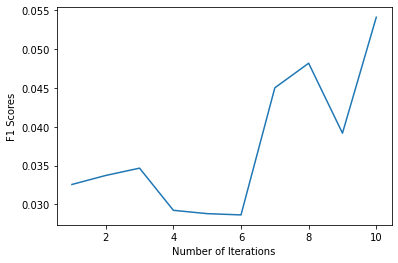

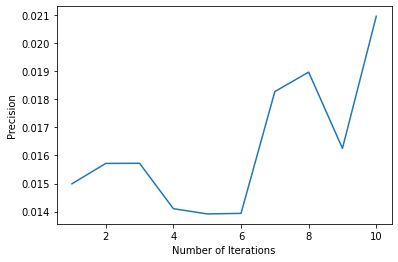

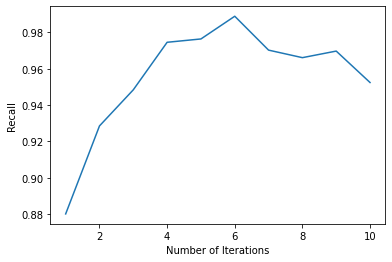

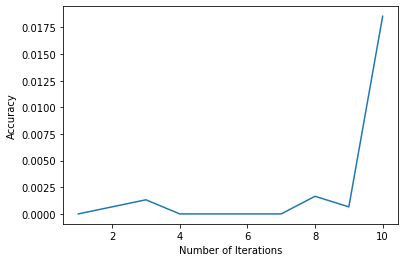

In [28]:
ytrain=torch.from_numpy(y_train)
ytest=torch.from_numpy(y_test)

train(model, xtrain, xtest, y_train_label.float(), ytrain.float(), ytest.float())
torch.save(model,'/content/drive/MyDrive/Dataset/MAGNET.pt')

In [ ]:
print(model)